<a href="https://colab.research.google.com/github/alracey/level4-project/blob/main/piecewise_quadratic_1d_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.9.0+cu126'

This section defines the target function f, the piecewise transform g, and the transformed function h.

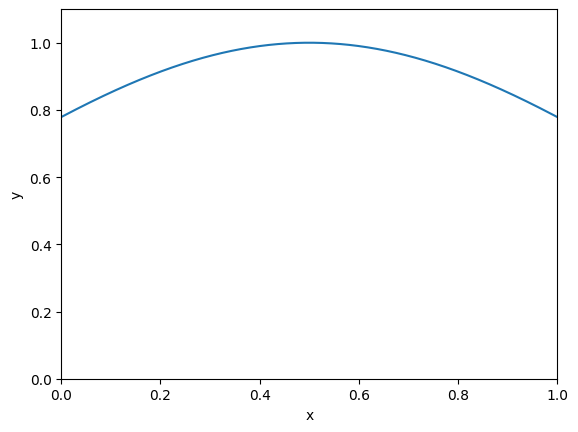

In [3]:
def f(x):
  return torch.exp(-((x-0.5)**2))

def plot_f(N):
  xs = torch.linspace(0, 1, N)
  f_evals = f(xs)

  fig = plt.figure()
  plt.plot(xs, f_evals)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.xlim(0, 1)
  plt.ylim(0, 1.1)
  plt.show()

  return fig

test = plot_f(1000)


REMEMBER you have now changed the definition of params to include the endpoints, to allow testing with the identity transformation.

In [4]:
### Parameters for testing throughout ###

D, n, K = 1, 10, 8

x = torch.rand(n)
params = torch.tensor([0.5, 0.1, 0.4, 0.5, 0.6, 0.2, 0.4, 0.7, 0.9])

Debugging g

In [5]:
### experimenting ###

'''Illustrative example for vectorised indexing'''
#row_indices = torch.arange(D).unsqueeze(1)
#i_values = torch.tensor([[2,1,3],
#                         [1,4,0]])
#v = torch.tensor([[0, 0.4, 1.2, 0.8, 1.0],
#                 [0, 0.3, 0.9, 0.7, 0.6]])
#print(v[row_indices, i_values])

# D is already 1 from kernel state

x = torch.rand(D, n) # Changed to (D, n)
i_values_list = [] # Changed name to avoid conflict with final i_values tensor
bins = torch.linspace(0, 1, K+1).repeat(D, 1) # Made bins (D, K+1)

for d_idx in range(D): # Loop for D dimensions
    i_d = torch.bucketize(x[d_idx], bins[d_idx], right=False) - 1
    i_values_list.append(i_d.clamp(min=0, max=K-1))
i_values = torch.stack(i_values_list, dim=0) # Now i_values is (D, n) tensor

row_indices = torch.arange(D).unsqueeze(1) # Added row_indices

# Assuming global params is 1D (K+1). Unsqueeze to (D, K+1) if D=1.
params_current_cell = params.unsqueeze(0)

x_left = bins[row_indices, i_values]    #shape (D, n)
x_right = bins[row_indices, i_values+1]
w_b = x_right - x_left

v = params_current_cell # Use the correctly shaped params

#area calcs
v_left_for_areas = v[:, :-1] # Changed from v[:-1] to v[:, :-1] as v is (D, K+1)
v_right_for_areas = v[:, 1:] # Changed from v[1:] to v[:, 1:]
bin_widths = bins[:, 1:] - bins[:, :-1]
bin_areas = 0.5 * (v_left_for_areas + v_right_for_areas) * bin_widths

#normalisation - enforce unit total area per dimension
total_area = bin_areas.sum(dim=1, keepdim=True)
v = v / total_area

# recompute bin areas with normalised PDF
v_left_for_areas = v[:, :-1] # Changed
v_right_for_areas = v[:, 1:] # Changed
new_bin_areas = 0.5 * (v_left_for_areas + v_right_for_areas) * bin_widths

#pdf heights
v_left = v[row_indices, i_values] # Changed indexing
v_right = v[row_indices, i_values+1] # Changed indexing
w_v = v_right - v_left    #slope of pdf inside bin (linear)

#cumulative area to left of x values
cum_areas = torch.zeros(D, n) # Changed to (D, n)
for d_idx in range(D): # Changed loop variable to avoid conflict with global d
  for i_idx in range(n): # Changed loop variable
    cum_areas[d_idx, i_idx] = torch.sum(new_bin_areas[d_idx, :i_values[d_idx, i_idx]])


#print('bins:', bins)
print('x values:', x)
print('i_values:', i_values)
#print('w_b:', w_b)
#print('w_v:', w_v)
print('v_left_for_areas:', v_left_for_areas)
print('v_right_for_areas:', v_right_for_areas)
print('bin widths:', bin_widths)
print('bin areas:', new_bin_areas)
print(torch.sum(new_bin_areas, dim=1))
print(cum_areas)

x values: tensor([[0.3849, 0.7879, 0.9804, 0.7491, 0.7737, 0.9412, 0.7610, 0.9358, 0.2461,
         0.8739]])
i_values: tensor([[3, 6, 7, 5, 6, 7, 6, 7, 1, 6]])
v_left_for_areas: tensor([[1.1111, 0.2222, 0.8889, 1.1111, 1.3333, 0.4444, 0.8889, 1.5556]])
v_right_for_areas: tensor([[0.2222, 0.8889, 1.1111, 1.3333, 0.4444, 0.8889, 1.5556, 2.0000]])
bin widths: tensor([[0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
bin areas: tensor([[0.0833, 0.0694, 0.1250, 0.1528, 0.1111, 0.0833, 0.1528, 0.2222]])
tensor([1.])
tensor([[0.2778, 0.6250, 0.7778, 0.5417, 0.6250, 0.7778, 0.6250, 0.7778, 0.0833,
         0.6250]])


In [6]:
def preprocess_params(params):
    """
    params: (D, K+1) unnormalised PDF heights
    returns:
      v:         (D, K+1) normalised PDF heights
      bin_areas: (D, K)   normalised bin areas
    """
    D, Kp1 = params.shape
    K = Kp1 - 1

    bins = torch.linspace(0, 1, K+1, device=params.device).repeat(D, 1)

    v = params
    v_left = v[:, :-1]
    v_right = v[:, 1:]
    bin_widths = bins[:, 1:] - bins[:, :-1]

    bin_areas = 0.5 * (v_left + v_right) * bin_widths
    total_area = bin_areas.sum(dim=1, keepdim=True)

    # normalise
    v = v / total_area
    bin_areas = bin_areas / total_area

    return v, bin_areas


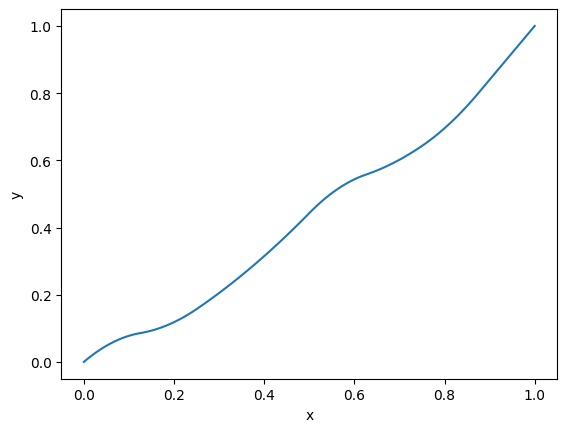

In [7]:
def g(x, params):

  '''
  PARAMS NOW INCLUDES ZEROS AND ONES TO SKIP CONCATENATING
  Piecewise quadratic transform with K bins, independent in x[0], x[1].
  This version does not yet predict bin widths.
  x.shape = (D, n); params.shape = (D, K+1) where D is dimensions, K is number of bins
  x ---> y
  '''

  #bins
  D, n = x.shape
  K = params.size(1) - 1

  #bin edges
  bins = torch.linspace(0, 1, K+1).repeat(D, 1)   #edges

  #find indices
  i_values = []
  for d in range(D):
    i_d = torch.bucketize(x[d], bins[d], right=False) - 1
    i_values.append(i_d.clamp(min=0, max=K-1))

  i_values = torch.stack(i_values, dim=0)   # shape (D, n)

  v, bin_areas = preprocess_params(params)

  #create row indices
  row_indices = torch.arange(D).unsqueeze(1)    #shape (D, 1)

  #bin edges
  x_left = bins[row_indices, i_values]    #shape (D, n)
  x_right = bins[row_indices, i_values+1]
  w_b = x_right - x_left   #shape (D, n)

  #pdf heights
  v_left = v[row_indices, i_values]
  v_right = v[row_indices, i_values+1]
  w_v = v_right - v_left    #slope of pdf inside bin (linear)

  #transform to local coordinate alpha
  alpha = (x - x_left) / (w_b + 1e-12)    #avoid instability

  #cumulative area to left of x values
  cum_areas = torch.zeros(D, n)
  for d in range(D):
    for i in range(n):
      cum_areas[d, i] = torch.sum(bin_areas[d, :i_values[d, i]])

  c_left = cum_areas

  #compute quadratic mappings
  result = c_left + ((alpha**2/2) * w_v * w_b) + (alpha * v_left * w_b)
  return result   #quadratic in alpha with shape (D, n)


#test

x_test = torch.linspace(0, 1, 100).repeat(D, 1)
params = torch.tensor([0.5, 0.1, 0.4, 0.5, 0.6, 0.2, 0.4, 0.7, 0.7])
g_test = g(x_test, params.unsqueeze(0)) # Added .unsqueeze(0) to make params (D, K+1)
#print(x_test)
#print(g_test)
plt.plot(x_test.squeeze(), g_test.squeeze())
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Debugging h

In [8]:
### experimenting with h ###

cdf_values = g_test
v, bin_areas = preprocess_params(params.unsqueeze(0)) # Unsqueeze params to make it (D, K+1)

#bins
bins = torch.linspace(0, 1, K+1).repeat(D, 1)


#v_left_for_areas = v[:, :-1]
#v_right_for_areas = v[:, 1:]
#bin_widths = bins[:, 1:] - bins[:, :-1]
#bin_areas = 0.5 * (v_left_for_areas + v_right_for_areas) * bin_widths #trapezium rule
c_edges = torch.zeros((D, K+1))   #cdf starts at 0
c_edges[:, 1:] = torch.cumsum(bin_areas, dim=1)

j_values = []
for d in range(D):
  j_d = torch.bucketize(cdf_values[d], c_edges[d], right=False) - 1
  j_values.append(j_d.clamp(min=0, max=K-1))

j_values = torch.stack(j_values, dim=0)   #these are correct so far

row_indices = torch.arange(D).unsqueeze(1)

#compute the edge positions
x_left = bins[row_indices, j_values]
x_right = bins[row_indices, j_values+1]
w_b = x_right - x_left    #bin width(s)

c_left = c_edges[row_indices, j_values]

v_left = v[row_indices, j_values]
v_right = v[row_indices, j_values+1]
w_v = v_right - v_left    #vertex differences

#solve quadratic to obtain alpha values

# coefficients
a = 0.5 * w_v * w_b
b = v_left * w_b
c = c_left - cdf_values

# linear vs quadratic bins
is_linear = torch.abs(w_v) < 1e-12

alpha = torch.empty_like(cdf_values)

# linear case
alpha[is_linear] = (cdf_values[is_linear] - c_left[is_linear]) / (
    v_left[is_linear] * w_b[is_linear]
)

# quadratic case
disc = torch.clamp(b*b - 4*a*c, min=0.0)
alpha[~is_linear] = (
    -b[~is_linear] + torch.sqrt(disc[~is_linear])
) / (2*a[~is_linear])

#obtain x values

x = x_left + (w_b*alpha)
jac = 1 / (v_left + w_v * alpha)
#jac_det = jac.prod(dim=0)

print('cdf_values:', cdf_values)
print('c_edges:', c_edges)
print('j_values:', j_values)
print('x_left:', x_left)
print('x_right:', x_right)
print('w_b:', w_b)
print('c_left:', c_left)
print('v:', v)
print('v_left:', v_left)
print('v_right:', v_right)
print('w_v:', w_v)
print('alphas:', alpha)
print('x:', x)
print('Jacobians:', jac)
print('h:', f(x) * jac)

cdf_values: tensor([[0.0000, 0.0112, 0.0216, 0.0313, 0.0402, 0.0484, 0.0558, 0.0625, 0.0685,
         0.0737, 0.0781, 0.0818, 0.0848, 0.0873, 0.0902, 0.0937, 0.0978, 0.1024,
         0.1076, 0.1133, 0.1196, 0.1264, 0.1339, 0.1418, 0.1504, 0.1595, 0.1688,
         0.1784, 0.1881, 0.1981, 0.2082, 0.2185, 0.2290, 0.2397, 0.2506, 0.2616,
         0.2728, 0.2843, 0.2959, 0.3077, 0.3197, 0.3318, 0.3442, 0.3568, 0.3695,
         0.3824, 0.3955, 0.4088, 0.4223, 0.4360, 0.4497, 0.4628, 0.4752, 0.4868,
         0.4976, 0.5078, 0.5171, 0.5258, 0.5336, 0.5408, 0.5472, 0.5528, 0.5577,
         0.5626, 0.5678, 0.5734, 0.5794, 0.5857, 0.5924, 0.5995, 0.6070, 0.6148,
         0.6230, 0.6316, 0.6406, 0.6499, 0.6599, 0.6704, 0.6814, 0.6930, 0.7052,
         0.7179, 0.7312, 0.7451, 0.7595, 0.7745, 0.7900, 0.8061, 0.8222, 0.8384,
         0.8545, 0.8707, 0.8869, 0.9030, 0.9192, 0.9354, 0.9515, 0.9677, 0.9838,
         1.0000]])
c_edges: tensor([[0.0000, 0.0857, 0.1571, 0.2857, 0.4429, 0.5571, 0.6429, 0.80

In [9]:
def h(y, params):

  '''
  Resulting function when the piecewise warp is applied, in accordance with change of variables formula.
  Integral should be preserved.
  '''

  D, n = y.shape
  K = params.size(1) -1

  #bins
  bins = torch.linspace(0, 1, K+1).repeat(D, 1)

  v, bin_areas = preprocess_params(params)

  #cumulative areas

  c_edges = torch.zeros((D, K+1))   #cdf starts at 0
  c_edges[:, 1:] = torch.cumsum(bin_areas, dim=1)

  #find indices
  j_values = []
  for d in range(D):
    j_d = torch.bucketize(y[d], c_edges[d], right=False) - 1
    j_values.append(j_d.clamp(min=0, max=K-1))

  j_values = torch.stack(j_values, dim=0)

  row_indices = torch.arange(D).unsqueeze(1)

  #compute the edge positions
  x_left = bins[row_indices, j_values]
  x_right = bins[row_indices, j_values+1]
  w_b = x_right - x_left    #bin width(s)

  c_left = c_edges[row_indices, j_values]

  v_left = v[row_indices, j_values]
  v_right = v[row_indices, j_values+1]
  w_v = v_right - v_left    #vertex differences

  #solve quadratic to obtain alpha values

  # coefficients
  a = 0.5 * w_v * w_b
  b = v_left * w_b
  c = c_left - y

  # linear vs quadratic bins
  is_linear = torch.abs(w_v) < 1e-12

  alpha = torch.empty_like(y)

  # linear case
  alpha[is_linear] = (y[is_linear] - c_left[is_linear]) / (
      v_left[is_linear] * w_b[is_linear]
  )

  # quadratic case
  disc = torch.clamp(b*b - 4*a*c, min=0.0)
  alpha[~is_linear] = (
      -b[~is_linear] + torch.sqrt(disc[~is_linear])
  ) / (2*a[~is_linear])

  #jacobians

  jac = 1 / (v_left + (w_v*alpha))

  #obtain x values
  x = x_left + (w_b*alpha)

  return f(x) * jac


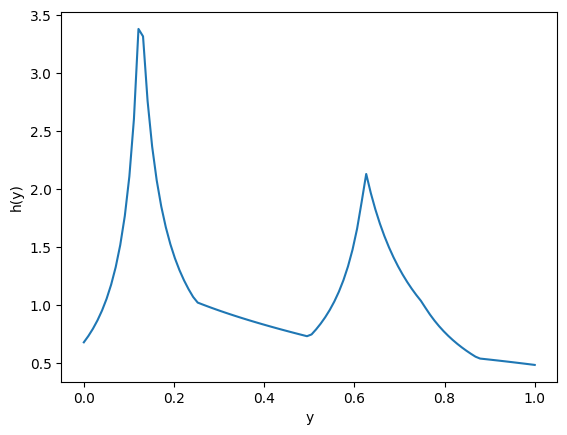

In [10]:
y_test = torch.linspace(0, 1, 100)
h_test = h(g_test, params.unsqueeze(0))
#print(h_test)
plt.plot(y_test, h_test.squeeze(0))
plt.xlabel('y')
plt.ylabel('h(y)')
plt.show()

Checking integral preservation and variance

In [11]:
#check integral is preserved using (naive) MC

###REFERENCE VALUE: 0.922562###
N = 1000000
#torch.manual_seed(42)
test_params = params

def MC_F(N):
  x = torch.rand(N)
  f_evals = f(x)
  F_est = torch.mean(f_evals)
  alpha_F = torch.std(f_evals) / torch.sqrt(torch.tensor(N))
  return F_est, alpha_F

def MC_H(N, params):
  y = torch.rand(N)
  h_evals = h(y.unsqueeze(0), params) # Unsqueezing y to (1, N) to match h's expected (D, n) input
  H_est = torch.mean(h_evals)
  alpha_H = torch.std(h_evals) / torch.sqrt(torch.tensor(N))
  return H_est, alpha_H

F_est, alpha_F = MC_F(N)
print(f'F estimate = {F_est} \u00b1 {alpha_F}')

H_est, alpha_H = MC_H(N, params.unsqueeze(0))
print(f'H estimate = {H_est} \u00b1 {alpha_H}')

F estimate = 0.9225719571113586 ± 6.708390719722956e-05
H estimate = 0.9224233031272888 ± 0.0004260328714735806


In [12]:
#check that variances are different in general
test_set = torch.rand(D, N)

f_var = torch.var(f(test_set))

h_for_var = h(test_set, test_params.unsqueeze(0)) # Unsqueeze test_params to make it (D, K+1)
h_var = torch.var(h_for_var)

print("F variance:", f_var)
print("H variance:", h_var)

F variance: tensor(0.0045)
H variance: tensor(0.1816)


Defining the training loop for optimisation of parameters in order to minimise variance

In [13]:
init_params = params.clone().detach().requires_grad_(True)
print(init_params)

tensor([0.5000, 0.1000, 0.4000, 0.5000, 0.6000, 0.2000, 0.4000, 0.7000, 0.7000],
       requires_grad=True)


In [16]:
#optimisation via training loop - loss function is the variance

def train_loop(x, init_params, K, epochs, lr):

  params = init_params.clone().detach().requires_grad_(True)
  optimiser = torch.optim.Adam([params], lr=lr)
  loss_values = torch.zeros(epochs)

  for epoch in range(epochs):
    g_eval = g(x, params.unsqueeze(0))
    h_eval = h(g_eval, params.unsqueeze(0))

    loss = torch.var(h_eval)
    loss_values[epoch] = loss

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return loss, loss_values, params

train_x = torch.rand(D, 1000)
test = train_loop(train_x, init_params=params, K=8, epochs=150, lr=0.02)
print(test[0], test[2])

tensor(8.6959e-07, grad_fn=<VarBackward0>) tensor([0.3376, 0.3767, 0.4075, 0.4274, 0.4340, 0.4274, 0.4075, 0.3768, 0.3375],
       requires_grad=True)


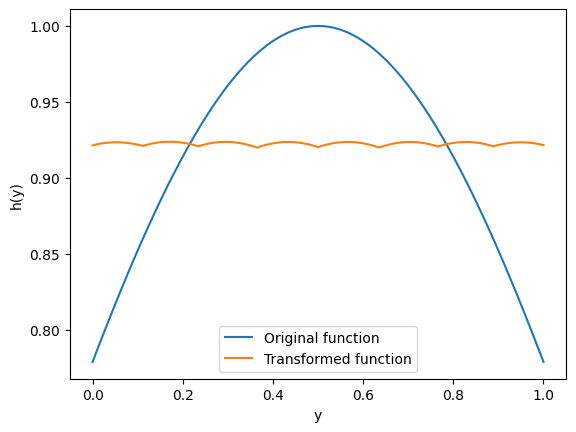

In [21]:
#plot of h with optimised parameters, comparing to original function

opt_params = test[2].detach()
y_plot = torch.linspace(0, 1, 1000)
h_test = h(y_plot.unsqueeze(0), opt_params.unsqueeze(0))

plt.plot(y_plot, f(y_plot), label='Original function')
plt.plot(y_plot, h_test.squeeze(0), label='Transformed function')
plt.legend()
plt.xlabel('y')
plt.ylabel('h(y)')
plt.show()